In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--nch_g", type=int, default=64)
parser.add_argument("--nch_d", type=int, default=64)
parser.add_argument("--z_dim", type=int, default=100) # noize dimension
opt = parser.parse_args(args=[])

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels // 8
        self.fx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.gx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.hx_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H * W).permute(0, 2, 1) # 転置
        gx = self.gx_1x1(x).view(B, -1, H * W)
        hx = self.hx_1x1(x).view(B, -1, H * W)
        s_mtx = torch.bmm(fx, gx)   # ミニバッチ毎に行列積を計算
        attention = self.softmax(s_mtx)
        o = torch.bmm(hx, attention)    # attention で重み付けられた入力が返ってくる
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, self_attention, z_dim=100, ngf=64, nc=3):   # nc=1 for black-and-white images
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4, 1, 0, True)
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1, True)
        self.convt3 = self.conv_trans_layers(4*ngf, 2*ngf, 4, 2, 1, True)
        self.attention1 = self_attention(2 * ngf)
        self.convt4 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1, True)
        self.attention2 = self_attention(ngf)
        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.attention1(out)
        out = self.convt4(out)
        out = self.attention2(out)
        out = self.convt5(out)
        return out


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/akimoto/gan_saka"

model_name = "SAGAN"
f_path_result = f"{BASE_DIR}/result/{model_name}"
f_path_params = f"{BASE_DIR}/params/{model_name}"

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

In [ ]:
model = Generator(SelfAttention, z_dim=opt.z_dim, ngf=opt.nch_g)
model.load_state_dict(torch.load(f"{BASE_DIR}/params/{model_name}/g_0499.pth"))
model.eval()

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (attention1): SelfAttention(
    (fx_1x1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (gx_1x1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (hx_1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-2)
  )
  (convt4): Sequential(
    (0): ConvTranspose2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

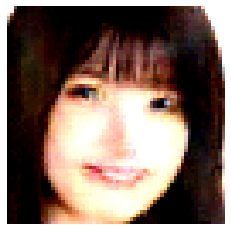

In [ ]:
# model.to(device)
# noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)
noise = torch.randn(64, opt.z_dim, 1, 1)
fake_imgs = model(noise)


# save imgs and params
for i in range(64):
    
    # show and save fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:25].detach() + 0.5, nrow=5)
    # print(fake_imgs[i])
    img = fake_imgs[i].detach().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    # plt.show()
    plt.axis('off')
    plt.savefig(fname=f"{BASE_DIR}/imgs_show/{i}.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)

    # save
    img = (fake_imgs[i].detach() + 0.5).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    # plt.show()
    plt.axis('off')
    plt.savefig(fname =f"{BASE_DIR}/imgs_show/{i}_p5.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)